# **WKT 2 TIN**

### Algorithm
1. Load all raster points within specified perimeter
2. For each area (Liegenschaft / BB)
   1. Retrieve the subset of all raster points withing the area + buffer
   2. Triangulate raster points
   3. Decimate mesh (only slightly)
   4. Calculate 3D coords of all vertices via ray tracing
   5. For each line segment in area boundary
      1. Slice along line segment (plane slice)
      2. Get line points -> Create line
   6. Add line points to final raster points
   7. Add line defintion to edges_list
   8. Retriangulate surface with new points and area boundaries
   9. Clip mesh by area object
3.  Decimate triangles of clipped mesh

4. Save as file or get raw data from clipped mesh

In [13]:
# Suppress warnings triggered when visualiazing meshes
import warnings
warnings.simplefilter("ignore", category=Warning)

### 0. Data preparation

In [14]:
import numpy as np
import pyvista as pv
import shapely

from pathlib import Path
from cs2bim.tin import mesh, raster, polygon


### Load raster data and define some variables

In [ ]:
base_path = Path("???")

file_name = "SWISSALTI3D_0.5_XYZ_CHLV95_LN02_2689_1285.xyz"
dtm_file = base_path / "DTM" / "swissalti3d_2020_2689-1285_0.5_2056_5728.xyz_small" / file_name
p_raster = np.loadtxt(dtm_file, delimiter=" ", skiprows=1)

In [16]:
grid_size = float(file_name.split("_")[1])

origin = p_raster.min(axis=0)

max_height_error = 0.05

### WKT string for area definition

WKT string must describe a polygon which can have holes.

<span style="color:red">Circular arcs are not supported!</span> Arcs must be divided into line segments in advance.

PostGIS [ST_CurveToLine](https://postgis.net/docs/ST_CurveToLine.html) provides such functionality. However, make sure to use ``flag 1`` to create symmetric output. Otherwise the adjacent areas might overlap.

In [17]:
wkt_1 = "POLYGON ((2689497.666 1285713.79, 2689498.889 1285731.781, 2689520.33 1285733.37, 2689526.57 1285739.783, 2689526.7778141554 1285738.9570255529, 2689526.979100669 1285738.1294361316, 2689527.173846992 1285737.3002833228, 2689527.3620409877 1285736.4696188113, 2689527.543670923 1285735.6374943752, 2689527.7187254773 1285734.8039618842, 2689527.887193739 1285733.9690732954, 2689528.0490652057 1285733.132880651, 2689528.2043297887 1285732.2954360736, 2689528.3529778086 1285731.4567917646, 2689528.495 1285730.617, 2689530.915 1285715.491, 2689530.985321365 1285715.06977686, 2689531.0631044987 1285714.64986757, 2689531.1483249185 1285714.2314043005, 2689531.2409558 1285713.8145187676, 2689531.3409679867 1285713.3993421902, 2689531.4483299986 1285712.9860052501, 2689531.5630080425 1285712.5746380491, 2689531.6849660226 1285712.1653700697, 2689531.8141655507 1285711.7583301333, 2689531.95056596 1285711.3536463603, 2689532.094124317 1285710.9514461292, 2689532.244795435 1285710.5518560368, 2689532.4025318893 1285710.1550018585, 2689532.5672840304 1285709.7610085083, 2689532.739 1285709.37, 2689532.9187515713 1285708.9814705504, 2689533.1053837556 1285708.5961989728, 2689533.298837531 1285708.2143071066, 2689533.4990517185 1285707.8359157224, 2689533.705963003 1285707.461144484, 2689533.91950595 1285707.0901119106, 2689534.139613027 1285706.7229353383, 2689534.366214628 1285706.3597308844, 2689534.59923909 1285706.00061341, 2689534.8386127222 1285705.6456964833, 2689535.084259824 1285705.2950923445, 2689535.3361027106 1285704.9489118697, 2689535.594061739 1285704.6072645362, 2689535.858055331 1285704.2702583878, 2689536.128 1285703.938, 2689540.047 1285699.114, 2689540.2231230964 1285698.8897502625, 2689540.392904527 1285698.6606617298, 2689540.556211422 1285698.4269136859, 2689540.712915978 1285698.1886890605, 2689540.8628955586 1285697.946174287, 2689541.006032791 1285697.699559156, 2689541.1422156566 1285697.4490366678, 2689541.271337579 1285697.1948028796, 2689541.393297509 1285696.9370567533, 2689541.508 1285696.676, 2689540.232 1285686.228, 2689535.845 1285663.677, 2689507.877 1285661.507, 2689498.261 1285662.404, 2689497.666 1285713.79))"
wkt_2 = "POLYGON ((2689451.159 1285635.981, 2689452.564 1285646.986, 2689461.637 1285718.051, 2689497.666 1285713.79, 2689498.261 1285662.404, 2689498.413 1285649.261, 2689491.529 1285630.777, 2689485.437 1285612.928, 2689475.761 1285613.794, 2689453.706 1285612.995, 2689452.931 1285615.047, 2689452.763199531 1285615.7299665285, 2689452.6028520055 1285616.4147211907, 2689452.449976469 1285617.1011826582, 2689452.304591077 1285617.7892694, 2689452.1667130985 1285618.4788996917, 2689452.0363589083 1285619.1699916257, 2689451.913543989 1285619.862463121, 2689451.798282927 1285620.5562319327, 2689451.690589412 1285621.2512156614, 2689451.5904762354 1285621.9473317638, 2689451.4979552873 1285622.6444975622, 2689451.413037556 1285623.3426302539, 2689451.335733128 1285624.0416469215, 2689451.2660511835 1285624.7414645427, 2689451.204 1285625.442, 2689451.147392736 1285626.1431045092, 2689451.098430274 1285626.8447843452, 2689451.0571184317 1285627.5469561524, 2689451.0234621153 1285628.2495365161, 2689450.9974653237 1285628.9524419734, 2689450.9791311454 1285629.6555890227, 2689450.968461758 1285630.358894134, 2689450.965458429 1285631.0622737575, 2689450.9701215154 1285631.7656443361, 2689450.9824504633 1285632.4689223126, 2689451.0024438077 1285633.172024141, 2689451.030099174 1285633.8748662968, 2689451.065413276 1285634.5773652855, 2689451.1083819196 1285635.2794376542, 2689451.159 1285635.981))"
wkt_3 = "POLYGON ((2689441.009 1285445.429, 2689441.627 1285454.376, 2689441.6893508127 1285454.7265340842, 2689441.759027256 1285455.075685858, 2689441.8359987824 1285455.4233022446, 2689441.920231645 1285455.7692308396, 2689442.011688914 1285456.113319979, 2689442.1103304927 1285456.4554188054, 2689442.216113134 1285456.7953773336, 2689442.328990459 1285457.1330465171, 2689442.4489129805 1285457.4682783128, 2689442.575828121 1285457.8009257466, 2689442.7096802373 1285458.130842977, 2689442.8504106454 1285458.4578853599, 2689442.997957646 1285458.7819095114, 2689443.1522565493 1285459.102773371, 2689443.313239708 1285459.4203362633, 2689443.4808365423 1285459.7344589608, 2689443.6549735735 1285460.045003744, 2689443.8355744556 1285460.351834462, 2689444.0225600083 1285460.654816592, 2689444.215848252 1285460.9538172993, 2689444.4153544446 1285461.2487054935, 2689444.620991117 1285461.5393518887, 2689444.832668113 1285461.8256290574, 2689445.050292628 1285462.1074114884, 2689445.2737692497 1285462.3845756412, 2689445.503 1285462.657, 2689455.883 1285474.038, 2689456.2310660323 1285474.4146931798, 2689456.5734572904 1285474.796551715, 2689456.910097129 1285475.1834901255, 2689457.2409101906 1285475.5754217943, 2689457.5658224216 1285475.972258986, 2689457.8847610895 1285476.3739128679, 2689458.1976547986 1285476.7802935282, 2689458.5044335076 1285477.191309998, 2689458.805028543 1285477.6068702699, 2689459.099372615 1285478.0268813195, 2689459.3873998346 1285478.451249126, 2689459.669045726 1285478.879878694, 2689459.944247242 1285479.312674073, 2689460.2129427777 1285479.7495383811, 2689460.475072185 1285480.1903738247, 2689460.730576786 1285480.6350817217, 2689460.9793993845 1285481.083562523, 2689461.2214842816 1285481.5357158345, 2689461.4567772853 1285481.991440441, 2689461.6852257247 1285482.4506343273, 2689461.9067784613 1285482.913194701, 2689462.1213859 1285483.3790180173, 2689462.329 1285483.848, 2689462.5291545102 1285484.3153902332, 2689462.7223650035 1285484.7856935007, 2689462.9085890995 1285485.2588066414, 2689463.0877859504 1285485.7346258792, 2689463.2599162487 1285486.2130468427, 2689463.424942238 1285486.6939645912, 2689463.5828277203 1285487.177273636, 2689463.7335380632 1285487.662867963, 2689463.8770402092 1285488.150641058, 2689464.0133026806 1285488.6404859284, 2689464.1422955883 1285489.132295127, 2689464.2639906383 1285489.625960776, 2689464.3783611367 1285490.12137459, 2689464.4853819963 1285490.6184279008, 2689464.5850297417 1285491.1170116798, 2689464.6772825164 1285491.6170165637, 2689464.762120084 1285492.1183328761, 2689464.8395238356 1285492.620850654, 2689464.909476793 1285493.124459671, 2689464.971963612 1285493.6290494604, 2689465.026970586 1285494.134509341, 2689465.0744856494 1285494.6407284406, 2689465.1144983796 1285495.1475957206, 2689465.147 1285495.655, 2689465.249 1285497.484, 2689465.307052409 1285498.6088495634, 2689465.3577037468 1285499.7340566842, 2689465.400951822 1285500.8595726667, 2689465.4367947616 1285501.9853488018, 2689465.465231015 1285503.1113363693, 2689465.486259352 1285504.23748664, 2689465.499878862 1285505.363750877, 2689465.5060889563 1285506.4900803391, 2689465.5048893653 1285507.6164262823, 2689465.496280141 1285508.7427399617, 2689465.4802616565 1285509.8689726335, 2689465.456834605 1285510.9950755576, 2689465.426 1285512.121, 2689465.3891299553 1285513.2436516301, 2689465.344907895 1285514.3660377013, 2689465.293335716 1285515.4881100666, 2689465.2344156294 1285516.6098205936, 2689465.168150164 1285517.7311211647, 2689465.094542162 1285518.8519636805, 2689465.0135947806 1285519.9723000603, 2689464.9253114923 1285521.0920822462, 2689464.8296960844 1285522.2112622035, 2689464.7267526584 1285523.3297919233, 2689464.6164856297 1285524.4476234245, 2689464.498899729 1285525.5647087565, 2689464.374 1285526.681, 2689464.211 1285528.047, 2689464.0761277135 1285529.1854882024, 2689463.9489888493 1285530.3248659403, 2689463.829589268 1285531.4650806834, 2689463.7179344757 1285532.606079863, 2689463.6140296194 1285533.747810874, 2689463.5178794893 1285534.8902210773, 2689463.429488519 1285536.0332578032, 2689463.3488607835 1285537.1768683526, 2689463.276 1285538.321, 2689463.2054695617 1285539.4671272154, 2689463.1427328954 1285540.6137074558, 2689463.0877929004 1285541.760687723, 2689463.0406521163 1285542.9080150013, 2689463.001312722 1285544.0556362579, 2689462.969776536 1285545.2034984473, 2689462.9460450155 1285546.3515485122, 2689462.9301192584 1285547.499733387, 2689462.922 1285548.648, 2689462.764 1285553.242, 2689462.747006801 1285554.1600363972, 2689462.7228084886 1285555.0779111362, 2689462.691406554 1285555.9955676699, 2689462.6528029316 1285556.9129494636, 2689462.607 1285557.83, 2689462.5544202225 1285558.742602544, 2689462.4946263703 1285559.6547608257, 2689462.4276221814 1285560.5664178196, 2689462.353411845 1285561.477516531, 2689462.272 1285562.388, 2689461.311 1285569.78, 2689459.255 1285576.139, 2689457.75 1285574.883, 2689446.931 1285603.66, 2689446.673677965 1285604.3472250926, 2689446.423713364 1285605.0371603474, 2689446.181134735 1285605.7297269986, 2689445.94596977 1285606.424845979, 2689445.7182453186 1285607.1224379311, 2689445.4979873775 1285607.8224232146, 2689445.2852210924 1285608.5247219156, 2689445.079970754 1285609.229253857, 2689444.882259795 1285609.9359386058, 2689444.6921107867 1285610.6446954836, 2689444.5095454366 1285611.355443576, 2689444.334584588 1285612.0681017402, 2689444.1672482155 1285612.7825886162, 2689444.0075554224 1285613.4988226348, 2689443.8555244403 1285614.2167220276, 2689443.7111726254 1285614.9362048355, 2689443.5745164575 1285615.6571889196, 2689443.4455715385 1285616.3795919688, 2689443.3243525885 1285617.1033315102, 2689443.2108734474 1285617.8283249184, 2689443.10514707 1285618.5544894252, 2689443.007185526 1285619.2817421278, 2689442.917 1285620.01, 2689442.839667522 1285620.697844378, 2689442.769244603 1285621.3864304752, 2689442.7057383405 1285622.0756888846, 2689442.649155137 1285622.7655501328, 2689442.599500695 1285623.4559446843, 2689442.556780019 1285624.1468029509, 2689442.5209974158 1285624.838055297, 2689442.492156492 1285625.5296320473, 2689442.470260155 1285626.2214634942, 2689442.4553106106 1285626.9134799042, 2689442.447309367 1285627.6056115252, 2689442.44625723 1285628.2977885932, 2689442.4521543058 1285628.9899413402, 2689442.465 1285629.682, 2689442.4861993897 1285630.4028043286, 2689442.514899883 1285631.1233489672, 2689442.551098371 1285631.8435558567, 2689442.5947909313 1285632.5633469755, 2689442.6459728316 1285633.2826443461, 2689442.7046385263 1285634.0013700451, 2689442.770781661 1285634.7194462111, 2689442.844395069 1285635.4367950528, 2689442.9254707764 1285636.1533388575, 2689443.014 1285636.869, 2689447.789 1285673.319, 2689452.063 1285706.68, 2689455.269 1285731.712, 2689464.889 1285733.299, 2689461.637 1285718.051, 2689452.564 1285646.986, 2689451.159 1285635.981, 2689451.1083819196 1285635.2794376542, 2689451.065413276 1285634.5773652855, 2689451.030099174 1285633.8748662968, 2689451.0024438077 1285633.172024141, 2689450.9824504633 1285632.4689223126, 2689450.9701215154 1285631.7656443361, 2689450.965458429 1285631.0622737575, 2689450.968461758 1285630.358894134, 2689450.9791311454 1285629.6555890227, 2689450.9974653237 1285628.9524419734, 2689451.0234621153 1285628.2495365161, 2689451.0571184317 1285627.5469561524, 2689451.098430274 1285626.8447843452, 2689451.147392736 1285626.1431045092, 2689451.204 1285625.442, 2689451.2660511835 1285624.7414645427, 2689451.335733128 1285624.0416469215, 2689451.413037556 1285623.3426302539, 2689451.4979552873 1285622.6444975622, 2689451.5904762354 1285621.9473317638, 2689451.690589412 1285621.2512156614, 2689451.798282927 1285620.5562319327, 2689451.913543989 1285619.862463121, 2689452.0363589083 1285619.1699916257, 2689452.1667130985 1285618.4788996917, 2689452.304591077 1285617.7892694, 2689452.449976469 1285617.1011826582, 2689452.6028520055 1285616.4147211907, 2689452.763199531 1285615.7299665285, 2689452.931 1285615.047, 2689453.706 1285612.995, 2689456.024 1285606.852, 2689463.97 1285585.803, 2689464.2840937492 1285584.9801258347, 2689464.591387721 1285584.1546882596, 2689464.8918609964 1285583.326743463, 2689465.1854931223 1285582.4963478046, 2689465.472264111 1285581.6635578098, 2689465.752154442 1285580.828430168, 2689466.0251450622 1285579.9910217274, 2689466.291217389 1285579.151389491, 2689466.5503533105 1285578.309590614, 2689466.802535187 1285577.4656823985, 2689467.0477458527 1285576.6197222902, 2689467.2859686147 1285575.7717678747, 2689467.517187258 1285574.9218768731, 2689467.741386043 1285574.070107139, 2689467.958549708 1285573.2165166528, 2689468.1686634705 1285572.3611635198, 2689468.3717130274 1285571.504105965, 2689468.5676845578 1285570.6454023288, 2689468.7565647205 1285569.7851110646, 2689468.9383406593 1285568.9232907332, 2689469.113 1285568.06, 2689470.939 1285565.481, 2689472.395 1285520.235, 2689470.905 1285495.279, 2689469.082 1285471.578, 2689471.778 1285468.308, 2689455.204 1285453.936, 2689449.787 1285443.961, 2689443.831 1285427.436, 2689441.009 1285445.429))"
wkt_4 = "POLYGON ((2689362.201 1285066.48, 2689362.331619094 1285067.3913248964, 2689362.4560409263 1285068.3035165549, 2689362.574259748 1285069.2165328334, 2689362.6862700973 1285070.1303315507, 2689362.7920668 1285071.0448704904, 2689362.8916449673 1285071.9601074012, 2689362.985 1285072.876, 2689369.628 1285134.562, 2689406.534 1285131.734, 2689421.806 1285086.43, 2689402.58 1285056.365, 2689362.201 1285066.48))"

wkt = [wkt_1, wkt_2, wkt_3, wkt_4]

### Visualize areas defined by WKT strings

Liegenschaften Nr. 5059, 11796, 5264, 1816
[Geoportal Schaffhausen](https://map.geo.sh.ch/geoportal/?project=Geoportal%20Schaffhausen&legend=Legende&rotation=0.00&scale=1638&center=2689467,1285593)

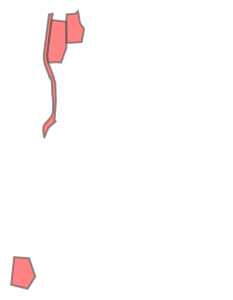

In [18]:
import shapely

polys = []
for i, wkt_str in enumerate(wkt):
    polys.append(shapely.from_wkt(wkt_str))

shapely.MultiPolygon(polys)

### Create ``polygon.Area`` object

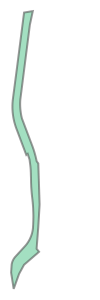

In [19]:
area = polygon.Area(wkt[2], origin=origin[:2])
area._geometry

### 1. Load all raster points within perimeter (in this case the whole tile)

In [20]:
dtm_points = raster.RasterPoints(p_raster, origin=origin)

### 2. For each area (Liegenschaft / BB)

   1. Retrieve the subset of all raster points withing the area + buffer
   2. Triangulate raster points
   3. Decimate mesh (only slightly)
   4. Calculate 3D coords of all vertices by ray tracing
   5. For each line segment in
      1. Slice along line segment (plane slice)
      2. Get line points -> Create line
   6. Add line points to final raster points
   7. Add line defintion to edges_list
   8. Retriangulate surface with new points and area boundaries
   9. Clip mesh by boundary


In [21]:
raster_points_buffer= dtm_points.within(area.get_geometry, buffer_dist= 3 * grid_size)
raster_points_within = dtm_points.within(area.get_geometry, buffer_dist= 0)


In [22]:
m = mesh.Mesh(raster_points_buffer)
m.mesh.save("mesh.stl")
m_clipped = m.clip_mesh_by_area(area, raster_points_within)

In [23]:
m_clipped.mesh.save("mesh_clipped.stl")

### 3. Decimate clipped mesh

In [24]:
m_clipped_decimated = m_clipped.decimate(max_height_error=max_height_error, grid_size=grid_size)

### Area consistency check

In [25]:
print(f"Area mesh 2D : {np.round(m_clipped.get_area_2d,5)}; Target area: {np.round(area.get_area, 5)}")


Area mesh 2D : 2711.31113; Target area: 2711.31256


In [26]:
m_clipped_decimated.check_area_consistency(area.get_area, treshold=0.1)

True

### Visualize results

### Mesh original with clip boundary

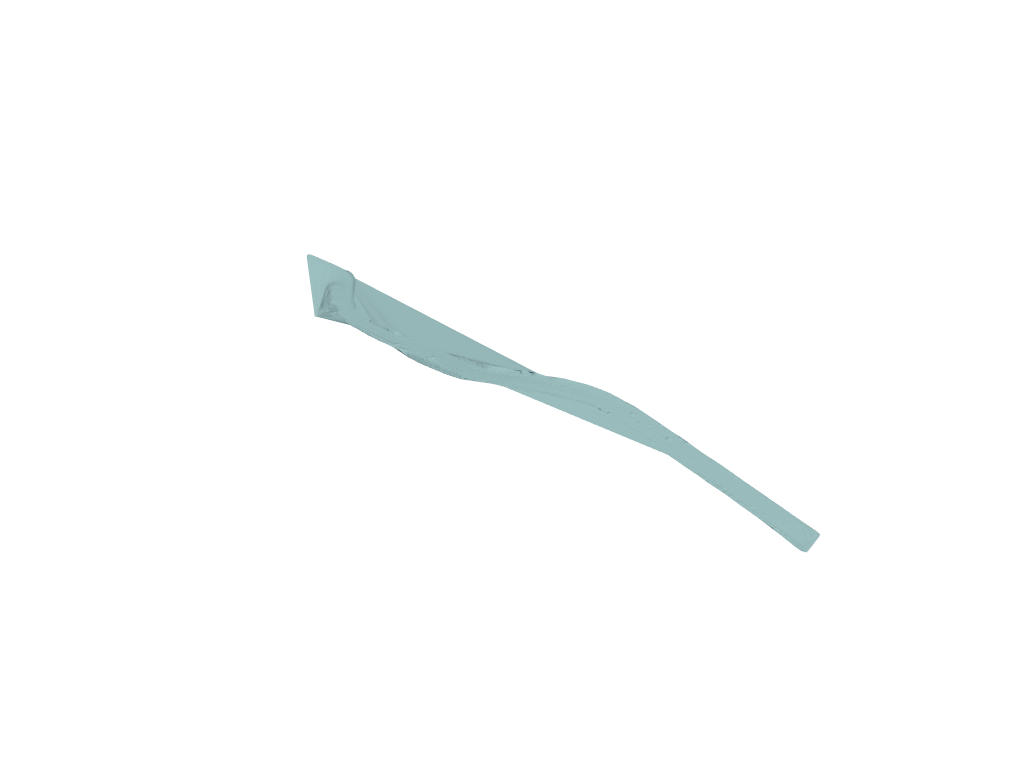

In [27]:
p = pv.Plotter()
#p.add_mesh(polygon.Boundary(area.get_exterior_points(), 10.0, 50).extrude(), opacity=0.2)
p.add_mesh(m.mesh, show_edges=False)
p.show()

### Mesh decimated with clip boundary

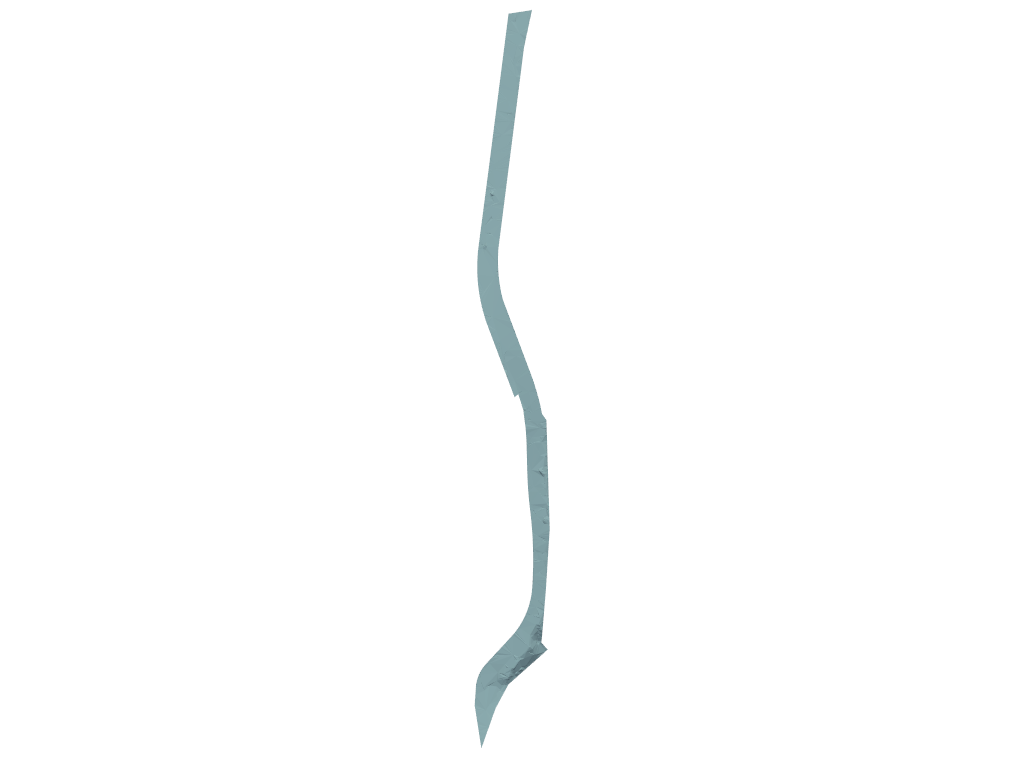

In [28]:
p = pv.Plotter()
#p.add_mesh(polygon.Boundary(area.get_exterior_points(), 10.0, 50).extrude(), opacity=0.2)
p.add_mesh(m_clipped_decimated.mesh, show_edges=False)
p.show(cpos="xy")

### Mesh decimated with edges

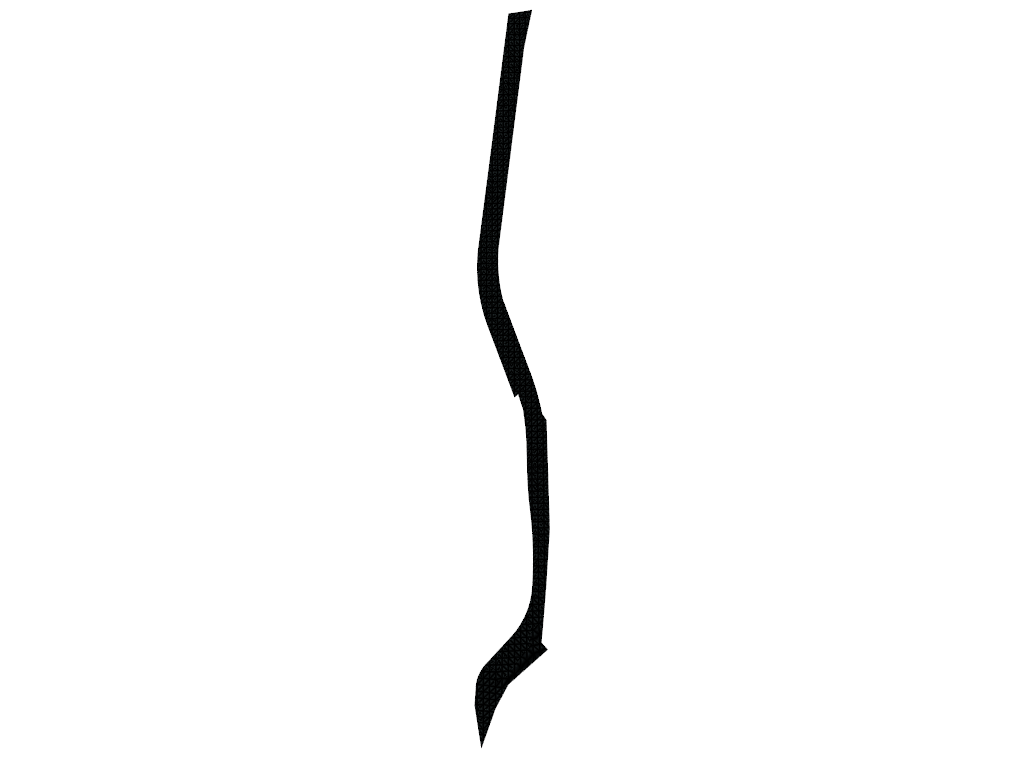

In [29]:
p = pv.Plotter()
p.add_mesh(m_clipped.mesh, show_edges=True)
p.show(cpos="xy")

In [30]:
m_clipped.n_triangles

24617

### Mesh decimated with edges

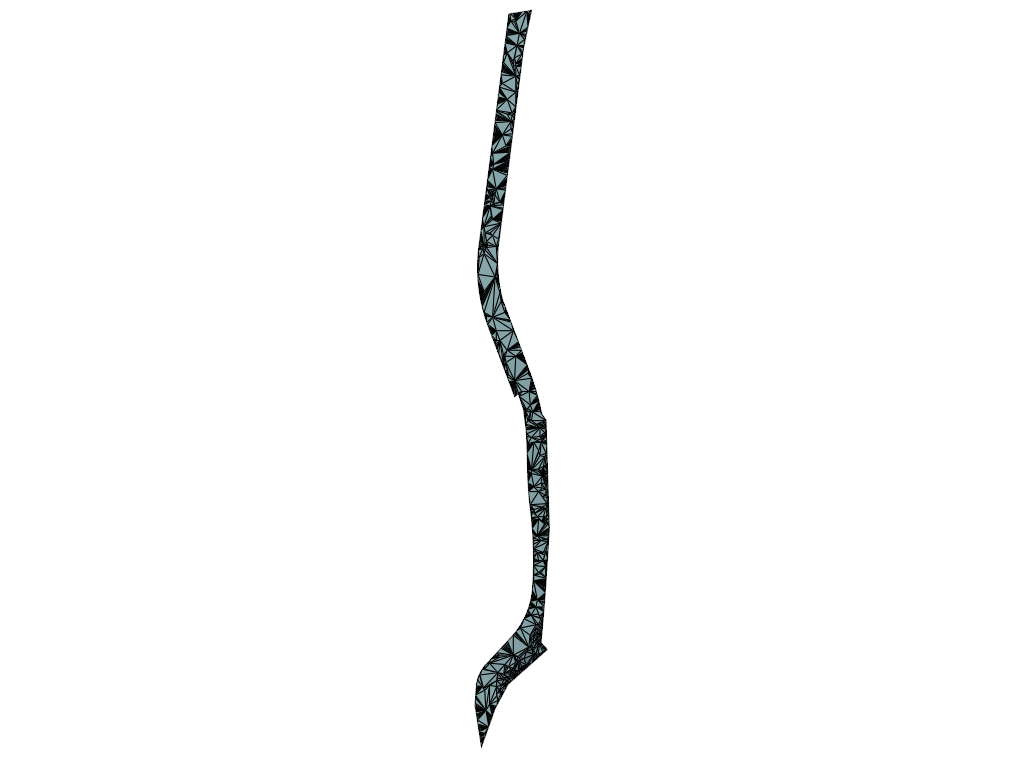

In [31]:
p = pv.Plotter()
p.add_mesh(m_clipped_decimated.mesh, show_edges=True)
p.show(cpos="xy")

In [32]:
m_clipped_decimated.n_triangles

4095

### Area consistency check

In [33]:
print(f"Area mesh 2D : {np.round(m_clipped.get_area_2d,5)}; Target area: {np.round(area.get_area, 5)}")

Area mesh 2D : 2711.31113; Target area: 2711.31256


In [34]:
m_clipped_decimated.check_area_consistency(area.get_area, treshold=0.1)

True

### 4. Get raw data from final mesh or save to file 

In [35]:
points, faces = m_clipped_decimated.get_data()

In [36]:
m_clipped.mesh.save("final_surface.stl")